##### PHYS591000 in 2022
# Lab 11
---
## Introduction 
In lab 11, we will practice RNN.  
* Build a Recurrent Neural Network(RNN)
* Learn LTSM structure

> **Useful Reference**
> 1. [Theory of RNN and LSTM](https://brohrer.mcknote.com/zh-Hant/how_machine_learning_works/how_rnns_lstm_work.html)
> 2. [RNN-LSTM Introduction](https://ithelp.ithome.com.tw/articles/10223055)
> 3. [Understanding LSTM -- a tutorial into Long Short-Term Memory Recurrent Neural Networks](https://arxiv.org/abs/1909.09586)
> 4. [Long Short-term Memory](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)

---
## Data Introduction  
[2d_ising model](https://en.wikipedia.org/wiki/Ising_model)  
* x_data : spin configuration (100 ensembles for each temperature)
* y_data : one-hot labels (0: paramagnetism, 1:ferromagnetic). 
* Temperature : Temperature for spin configuration. T_c ~ 2.38 corresponding to the maximum point of magnetic susceptibility.
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phys591000-2022-week11/2d_Ising.pickle
/kaggle/input/phys591000-2022-week11/test_data.npz
/kaggle/input/phys591000-2022-week11/c2d_yso.pickle


## Lab 11
---

### 1.0 Enviroment setting 

**Please just run this cell to avoid the problem in model training.**

In [2]:
##############################################################################
# Code for 1.0
##############################################################################
# import
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

##############################################################################

2022-04-27 13:46:22.370084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 13:46:22.433553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:22.541195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:22.542509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### 1.1 Load Data
* Load the 2d_ising dataset.  
    * Print out the keys of dataset.  
    * Pick up `x_data` and `y_data` and `T`.  
    * Print out the shape of `x_data` and `y_data` and `T`.  

In [3]:
##############################################################################
# Code for 1.1
# 
##############################################################################
# Please code in this cell

# import packages
import pickle
import numpy as np

with open('/kaggle/input/phys591000-2022-week11/2d_Ising.pickle', 'rb') as f:
    data = pickle.load(f)

x_data = data['x_data']
y_data = data['y_data']
T      = data['Temperature']

print(f"x_data shape is {x_data.shape}")
print(f"y_data shape is {y_data.shape}")
print(f"T shape is {T.shape}")

##############################################################################

x_data shape is (1001, 100, 10, 10)
y_data shape is (1001, 2)
T shape is (1001,)


### 1.2 Visulize the x_data of 2d_ising dataset  
* There are 1001 data in dataset.  
* Each one has 100 images that is 10x10 in x_data.  
* Please plot 100 images in a figure.  

**Only need to print index 0 and 1001 in x_data**  
**There should be 2 figures, each has 100 images**  

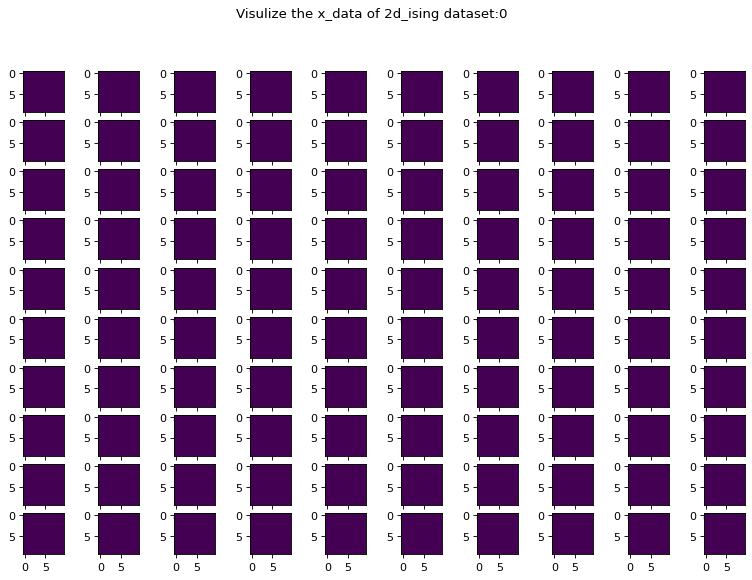

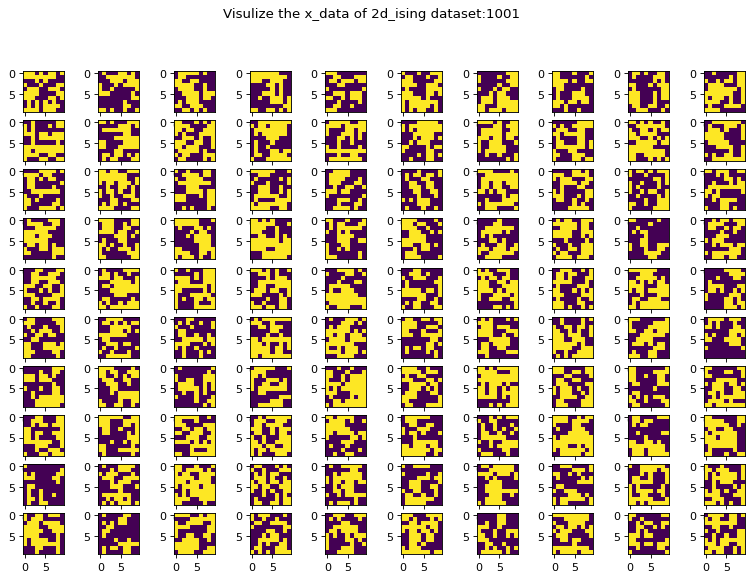

In [4]:
##############################################################################
# Code for 1.2
# 
##############################################################################
# Please code in this cell

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(12,8), dpi=80)
plt.suptitle('Visulize the x_data of 2d_ising dataset:0')
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(x_data[0,i,:,:])
plt.show()

fig = plt.figure(figsize=(12,8), dpi=80)
plt.suptitle('Visulize the x_data of 2d_ising dataset:1001')
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(x_data[1000,i,:,:])
plt.show()
##############################################################################

### 1.3 Preprocessing  
* Please set training date.   
    * 2d_ising  
        * x_data -> X_train  
        * T -> y_train  
* Normalize the each data.  
* Flatten the each data.  
* Print out the data shpaes.  

In [5]:
##############################################################################
# Code for 1.3
# 
##############################################################################
# Please code in this cell

X_train = x_data
y_train = T

for i in range(1001):
    for j in range(100):
        X_train[i][j] = (X_train[i][j]+1)/2    
    y_train[i] = y_train[i]/y_train.max()
    
re_X_train = X_train.reshape(1001,100,100)

print(f"The shape of the X_train become {re_X_train.shape}")
print(f"The shape of the y_train still {y_train.shape}")
##############################################################################

The shape of the X_train become (1001, 100, 100)
The shape of the y_train still (1001,)


### 1.4 Build the model
Bulid a LSTM model  

* Please create a RNN architecture as follow.  
    * input_shape = (data shape[1], data shape[2]) -> 
        LSTM layer (filters=4, return_sequences=True) ->
        Flatten ->    
        Output Dense layer with 1 neuron 

* **linear** will be activation function for output layer.
* `Adam` will be the optimizer and `mse` will be the loss function.
* Please visualize or print your Architecture.  
<!-- * Input the 2d_ising x training data.    -->

In [6]:
##############################################################################
# Code for 1.4
# 
##############################################################################
# Please code in this cell

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

model = Sequential()       
model.add(LSTM(4, return_sequences=True, input_shape = (re_X_train.shape[1], re_X_train.shape[2])))
model.add(Flatten())                  
model.add(Dense(1))          

model.compile(optimizer = 'adam', loss = 'mse',metrics=['accuracy'])

model.summary()
##############################################################################

2022-04-27 13:46:40.625186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:40.626047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:40.626679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:40.627536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:46:40.628197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 4)            1680      
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


### 1.5 Train the model by 2d_ising dataset  
* Please set up the callback of `EarlyStopping`:  
    * monitor="mse"  
    * patience=10  
    * verbose=0  
    * mode="auto"  
* Please train your RNN model with `batch_size=5` and `epochs=1000`.
    * x = X_train, 
    * y = y_train,  
    * validation_split=0.1  
    
    
* Please save your model and name it to be `model_LSTM_2d_ising.h5`.

In [7]:
##############################################################################
# Code for 1.5
# 
##############################################################################
# Please code in this cell

callbacks = tf.keras.callbacks.EarlyStopping(
                monitor='mse', patience=10, verbose=0, mode='auto')

history = model.fit(re_X_train, y_train, epochs = 1000, batch_size = 5, validation_split=0.1, callbacks=callbacks, verbose=0)

model.save("model_LSTM_2d_ising.h5")

##############################################################################

2022-04-27 13:46:41.155351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-27 13:46:43.545519: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


### 1.6 Plot the learning curve of 2d_ising dataset  
* Print out the keys of history.history.  
* Plot the accuracy curve.  
* Plot the loss curve.  

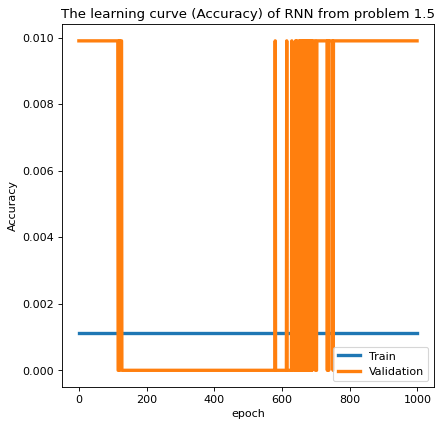

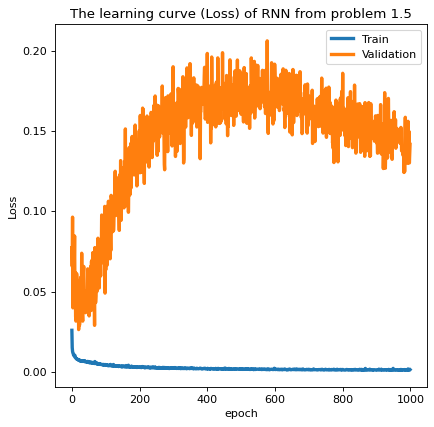

In [8]:
##############################################################################
# Code for 1.6
# 
##############################################################################
# Please code in this cell

fig = plt.figure(figsize=(6,6), dpi=80)
plt.title("The learning curve (Accuracy) of RNN from problem 1.5")
plt.plot(history.history['accuracy'], lw=3, label='Train')
plt.plot(history.history['val_accuracy'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


fig = plt.figure(figsize=(6,6), dpi=80)
plt.title("The learning curve (Loss) of RNN from problem 1.5")
plt.plot(history.history['loss'], lw=3, label='Train')
plt.plot(history.history['val_loss'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##############################################################################

### 1.7
Discussion for 1.6  

1. According to the accuracy curve and loss curve, please try your best to commnet on the performance of 2d-ising in RNN.  
2. Is this a regression problem or a classification problem? Which metric is better?  

---
Please write your discussion in this cell:     


1. RNN model will use the output which were generated by the past layer's to input the next layer, which become a recursive-like type to do model training.<br>
In Ising model ,the temperatur is relative to the spin configraution. The different temperature will have very different configraution, although in same ensemable. So for RNN model use the past experience(output) will not improve the following layer accuracy.
<br>
2. We consider that this is a regression probelm. Beacuse the model will predict the linear temperature result, which is generated by the linear model.<br>
We can also demonstrate linear by checking what loss function we use. 'mse'(mea square error), which is the error calculation method for linear function.

---

## Competition Submission Guideline

We will learn how to do competition submission in the following cell.


### 1.8 Apply Trained Model on Test Dataset

* 1 Please load **test_data.npz** as test data  
    * test_data = np.load("./XXXXXX.npz")["test_data"]

* 2 Apply your normalization method on this `test_data`
 
* 3 Apply trained model on this `test_data`
    * prediction = model.predict(XXXX)

* 4 Rescale your prediction into real scale

* 5 Please show your prediction data shape

* 6 Print **TOP 10** predicted values


In [9]:
##############################################################################
# Code for 1.8
# 
##############################################################################
# Please code in this cell

test_data = np.load('/kaggle/input/phys591000-2022-week11/test_data.npz')["test_data"]


for i in range(100):
    for j in range(100):
        test_data[i][j] = (test_data[i][j]+1)/2    

        
re_test_data = test_data.reshape(100,100,100)
print(f"The shape of the test_data is {re_test_data.shape}")

# predict 
prediction = model.predict(re_test_data)
# rescale
prediction = prediction*5
prediction = prediction.reshape(100)

print("The top 5 prediction is:")
print(prediction[0:10])

##############################################################################

The shape of the test_data is (100, 100, 100)
The top 5 prediction is:
[3.4598682 1.9136934 4.20279   1.4653331 3.9156294 1.2145872 1.9222786
 1.7727599 4.7141676 4.6778126]


---

### 1.9 Prepare Submission Format

* 1 Please create a **Pandas DataFrame**

* 2 Create a column with the name `id` and then fill 0~99 in this column

* 3 Create a column with the name `prediction` and then fill your prediction in this column

* 4 Save this pandas dataFrame into a csv file with `index=0` and name this file as `your_ID.csv`


In [10]:
##############################################################################
# Code for 1.9
# 
##############################################################################
# Please code in this cell

d = {'id': list(range(100)),
     'prediction': prediction}

df = pd.DataFrame(data=d)

df.to_csv('110022559_110022513.csv', index=0)  

##############################################################################

---

### 1.10 Download File and Submit

* 1 Please download your `your_ID.csv`  from `Output`

* 2 Submit this file to [Submit Predictions](https://www.kaggle.com/competitions/phys591000-2022-week11/submit)

* 3 Please write down your score from leaderboard
    * the score is **Mean Square Error**

In [11]:
##############################################################################
# Code for 1.10
# 
##############################################################################
# Please code in this cell      

print("The score of our team is: {:.2f}".format(0.41114))

##############################################################################

The score of our team is: 0.41
